In [4]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import cv2

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display

%tensorflow_version 1.x
import tensorflow as tf

import ipywidgets as widgets

TensorFlow 1.x selected.


In [5]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, frozen_graph):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    f = open(frozen_graph, "rb")
    graph_df = tf.GraphDef.FromString(f.read())

    if not os.path.isfile(frozen_graph) or graph_df is None:
      raise RuntimeError('Cannot find inference graph.')

    with self.graph.as_default():
      tf.import_graph_def(graph_df, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(image)]})
    seg_map = unify_labels(batch_seg_map[0])
    

    return image, seg_map


def unify_labels(seg_map):
  seg_map = np.where(seg_map==6, 5, seg_map) 
  seg_map = np.where(seg_map==7, 5, seg_map) 
  seg_map = np.where(seg_map==14, 15, seg_map) 
  seg_map = np.where(seg_map==16, 17, seg_map)
  seg_map = np.where(seg_map==18, 19, seg_map) 

  return seg_map

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(30, 5))
  grid_spec = gridspec.GridSpec(1, 6, width_ratios=[6, 6, 6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  plt.subplot(grid_spec[3])
  blob_image, biggest_blobs, _ = get_contours_with_colors(seg_image, [body_color, pants_color])
  plt.imshow(image)
  plt.imshow(blob_image, alpha=0.7)
  plt.axis('off')
  plt.title('blob overlay')

  plt.subplot(grid_spec[4])
  plt.imshow(image)
  plt.imshow(biggest_blobs, alpha=0.7)
  plt.axis('off')
  plt.title('biggest blob overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[5])
  plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'UpperClothes', 'Dress', 'Coat',
    'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-Arm', 'Arm',
    'Left-leg', 'Leg', 'Left-shoe', 'Shoe'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

MODEL = DeepLabModel('/content/drive/MyDrive/TFM/model_19_60k/frozen_inference_graph.pb')

In [105]:
body_color = FULL_COLOR_MAP[5]
pants_color = FULL_COLOR_MAP[9]

In [114]:
def biggest_contours(contours_body, contours_pants):  
  biggest_body = 0
  biggest_pants = 0

  for index, body in enumerate(contours_body):
    if cv2.contourArea(body) > cv2.contourArea(contours_body[biggest_body]):
        biggest_body = index

  for index, pants in enumerate(contours_pants):
    if cv2.contourArea(pants) > cv2.contourArea(contours_pants[biggest_pants]):
        biggest_pants = index
  return biggest_body, biggest_pants

In [126]:
def crop_roi(im, seg_map):
  crop_seg_ids_torso = np.where(seg_map == 5)
  crop_seg_ids_pants = np.where(seg_map == 9)

  upper_point = min(crop_seg_ids_torso[0])
  lower_point = max(crop_seg_ids_pants[0])

  l_point = min(min(crop_seg_ids_torso[1]), min(crop_seg_ids_pants[1]))
  r_point = max(max(crop_seg_ids_torso[1]), max(crop_seg_ids_pants[1]))

  crop = im.crop((l_point, upper_point, r_point, lower_point))

  seg_image = label_to_color_image(seg_map).astype(np.uint8)

  _, _, contours = get_contours_with_colors(seg_image, [body_color, pants_color])
  i_body, i_pants = biggest_contours(contours[0], contours[1])

  return crop

In [120]:
def get_contours_with_colors(seg_map, colors):
  seg_map_body = np.copy(seg_map)
  seg_map_pants = np.copy(seg_map)
  seg_map_biggest_blobs = np.copy(seg_map)

  seg_map_body[seg_map_body == body_color] = 255
  seg_map_pants[seg_map_pants == pants_color] = 255

  imgray_body = cv2.cvtColor(seg_map_body, cv2.COLOR_BGR2GRAY)
  imgray_pants = cv2.cvtColor(seg_map_pants, cv2.COLOR_BGR2GRAY)

  _, thresh_body = cv2.threshold(imgray_body, 254, 255, cv2.THRESH_BINARY)
  _, thresh_pants = cv2.threshold(imgray_pants, 254, 255, cv2.THRESH_BINARY)

  contours_body, _ = cv2.findContours(thresh_body, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours_pants, _ = cv2.findContours(thresh_pants, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  biggest_body, biggest_pants = biggest_contours(contours_body, contours_pants)

  cv2.drawContours(seg_map, contours_body, -1, (0,255,0), 3)
  cv2.drawContours(seg_map, contours_pants, -1, (255,255,0), 3)

  cv2.drawContours(seg_map_biggest_blobs, contours_body, biggest_body, (0,255,0), 3)
  cv2.drawContours(seg_map_biggest_blobs, contours_pants, biggest_pants, (255,255,0), 3)

  return seg_map, seg_map_biggest_blobs, [contours_body, contours_pants]

In [27]:
image_list_siani = os.listdir('/content/drive/MyDrive/TFM/TGC_places/TGC_places/Ayagaures/')
image_picker_siani = widgets.Dropdown(options=image_list_siani, value=image_list_siani[0], disabled=False)
image_picker_siani

Dropdown(options=('10_Ayagaures_frame_11_57_17_000.jpg', '12_Ayagaures_frame_16_18_10_000.jpg', '190_Ayagaures…

running deeplab on image 451_Ayagaures_frame_16_33_28_000.jpg...


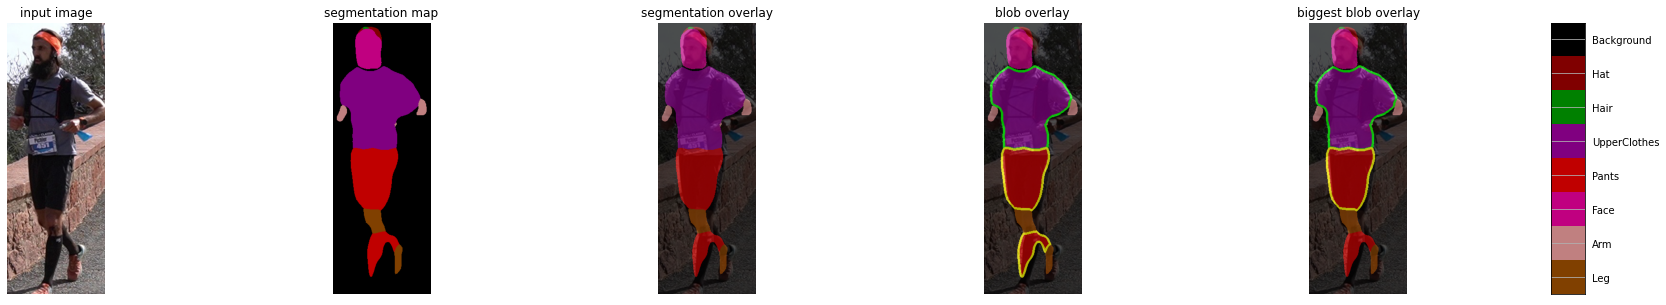

In [121]:
def run_visualization_siani(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/TGC_places/TGC_places/Ayagaures/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

run_visualization_siani(image_picker_siani.value)

running deeplab on image 451_Ayagaures_frame_16_33_28_000.jpg...
<class 'list'>
(203, 566)
(166, 437)


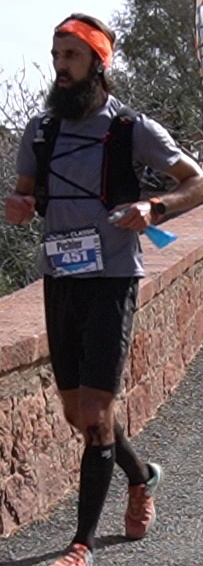

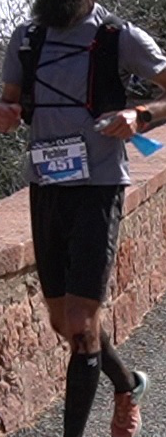

In [127]:
def run_crop_siani(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/TGC_places/TGC_places/Ayagaures/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  return resized_im, crop_roi(resized_im, seg_map)

img, crop = run_crop_siani(image_picker_siani.value)
print(img.size)
print(crop.size)
display(img, crop)

In [110]:
image_list = os.listdir('/content/drive/MyDrive/TFM/lip_trainval_images/TrainVal_images/val_images/')
image_picker = widgets.Dropdown(options=image_list, value=image_list[0], disabled=False)
image_picker

Dropdown(options=('559665_189146.jpg', '566054_513371.jpg', '56002_443976.jpg', '561464_1188760.jpg', '564566_…

running deeplab on image 560576_1218142.jpg...


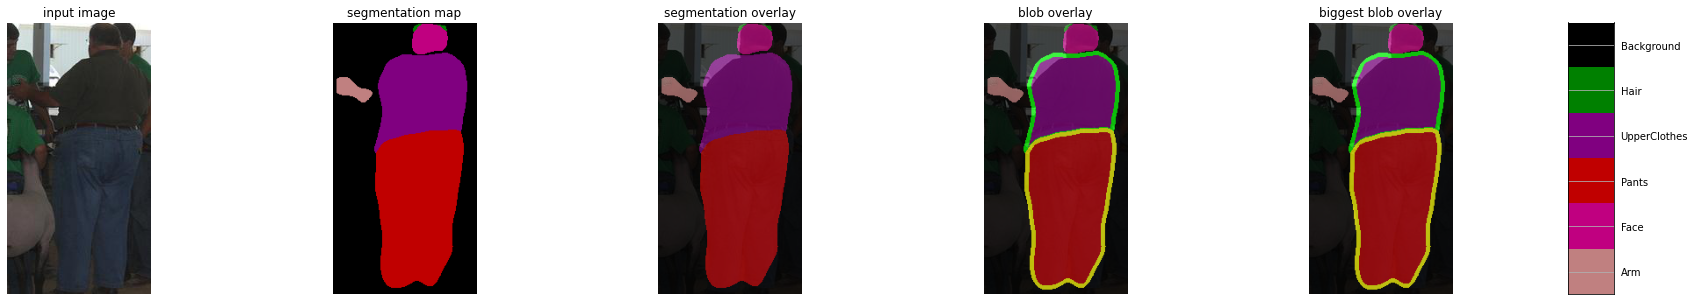

In [112]:
def run_visualization(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/lip_trainval_images/TrainVal_images/val_images/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

run_visualization(image_picker.value)

In [22]:
image_list = os.listdir('/content/drive/MyDrive/TFM/test_images/')
image_picker = widgets.Dropdown(options=image_list, value=image_list[0], disabled=False)
image_picker

Dropdown(options=('Fancy-dress-costume-at-the-2012-Virgin-London-Marathon-802356.jpg', 'tokyo_marathon_2014_co…

running deeplab on image tokyo_marathon_2014_cosplay_3596.jpg...


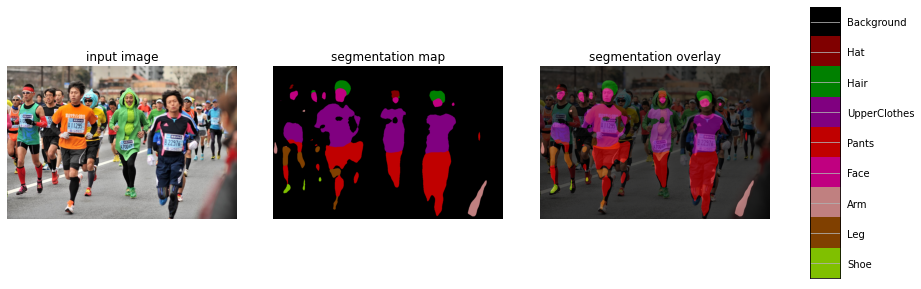

In [23]:
def run_tests_visualization(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/test_images/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

run_tests_visualization(image_picker.value)

running deeplab on image tokyo_marathon_2014_cosplay_3596.jpg...
(1060, 704)
(908, 516)


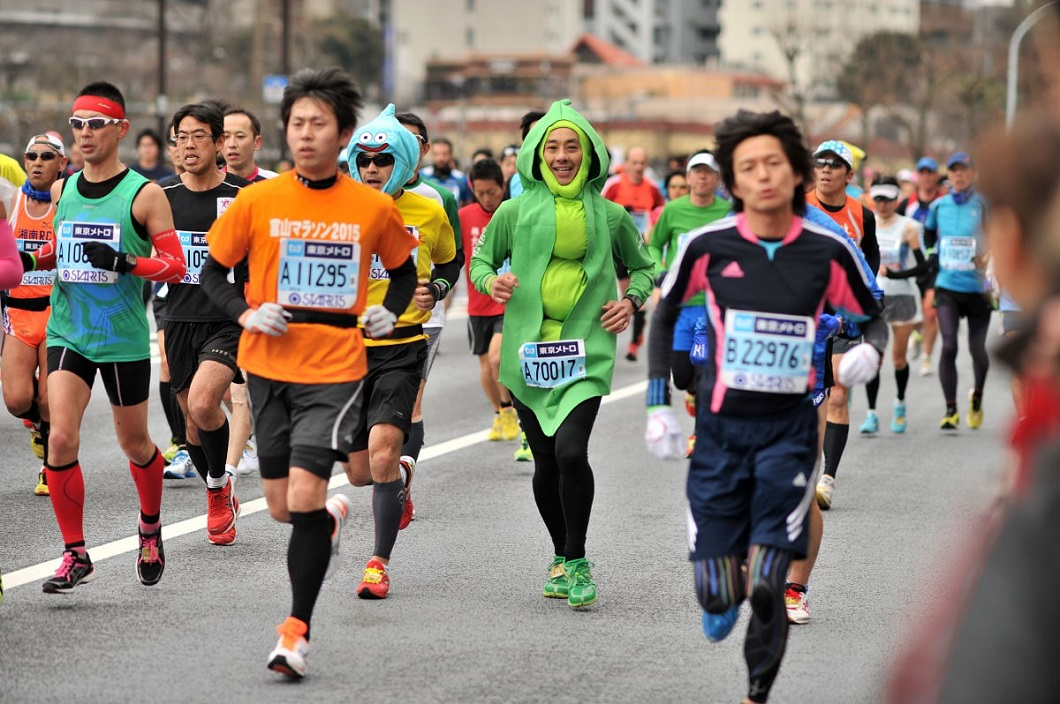

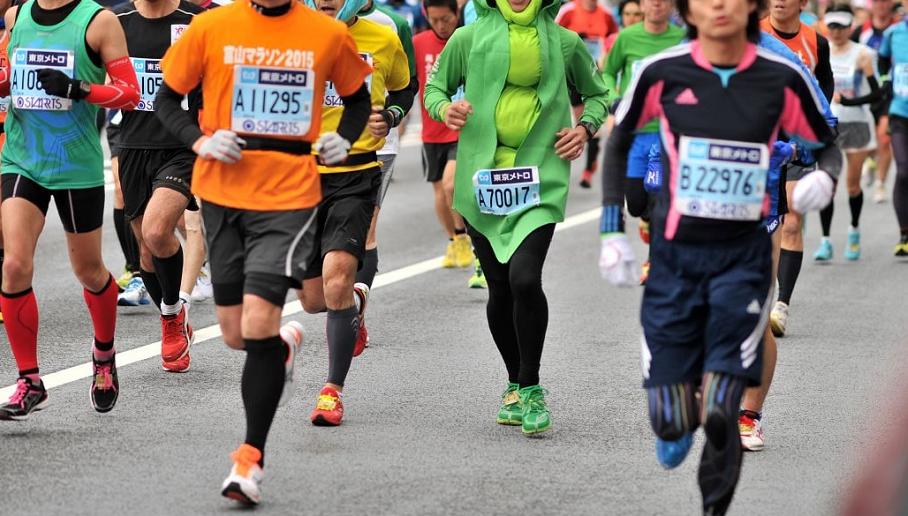

In [24]:
def run_crop_test(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/test_images/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  return resized_im, crop_roi(resized_im, seg_map)

img, crop = run_crop_test(image_picker.value)
print(img.size)
print(crop.size)
display(img, crop)